In [25]:
from skimage.io import imread,imshow,imsave
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [26]:
from skimage.color import rgb2hsv,hsv2rgb
from skimage.morphology import disk
from skimage.morphology import opening,closing,erosion,dilation

In [27]:
im=imread('road.jpg')

[0.00809781 0.00940661 0.01074861 0.01207164 0.0133757  0.01466869
 0.01597275 0.01727681 0.01865042 0.01995448 0.02137393 0.0227997
 0.02414643 0.02557695 0.02712917 0.02861027 0.03014985 0.03177004
 0.03351985 0.03518589 0.03693728 0.03869657 0.04050803 0.04227839
 0.04415149 0.04594556 0.04777282 0.04978661 0.05178933 0.05376517
 0.05582006 0.05789707 0.05983972 0.06194202 0.06406961 0.06619562
 0.06829793 0.07038916 0.07242824 0.07455899 0.07663284 0.07879837
 0.08090383 0.08296504 0.08503256 0.08725025 0.08943791 0.09164138
 0.09377529 0.09593924 0.09810319 0.10026713 0.10238998 0.10472148
 0.10705773 0.10920113 0.11145359 0.11370922 0.11594904 0.11813354
 0.12041129 0.1226606  0.1249589  0.12722559 0.12952074 0.13187753
 0.13413632 0.13630817 0.13857802 0.14093323 0.14320625 0.1455251
 0.14807948 0.15058485 0.15323723 0.15603187 0.15893715 0.16169227
 0.1648236  0.16788063 0.17082543 0.17369436 0.17649216 0.17927099
 0.1819945  0.18464846 0.187402   0.19032941 0.19344967 0.196606

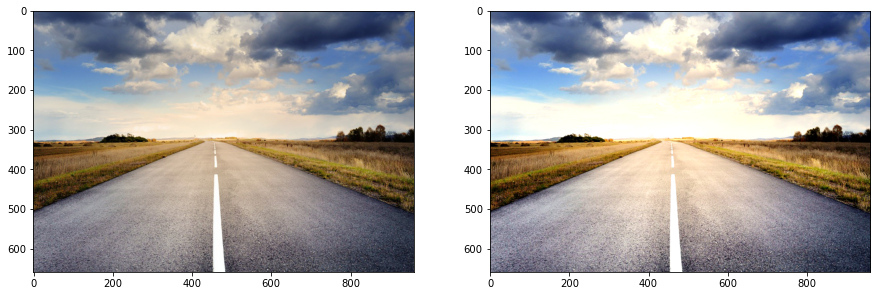

In [38]:
def cumul_hist(im):
    cumul_hist = np.zeros((256,))
    c = 0
    for v in range(256):
        c += (im==v).sum()
        cumul_hist[v] = c
    cumul_hist /= cumul_hist.max()
    return cumul_hist

# print(im)
# h = cumul_hist(im)
for i in range(3):    
    h = cumul_hist(im[:,:,i])
# plt.figure()
# plt.plot(h)
# plt.show()


print(h)

# for v in range(256):
#     for i in range(3):
#         if h[i][v] > 0.02: break
# Tmin = v-1

for v in range(256):
    if h[255-v] < 0.98: break
Tmax = (255-v)+1

print(Tmin,Tmax)


LUT=np.arange(256)               #.astype('float')会更平滑但是我们要integer
LUT[:Tmin]= 0
LUT[Tmax:]= 255
LUT[Tmin:Tmax]= (255/(Tmax-Tmin))*(LUT[Tmin:Tmax]-Tmin)

im1=LUT[im]

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im1)
plt.show()


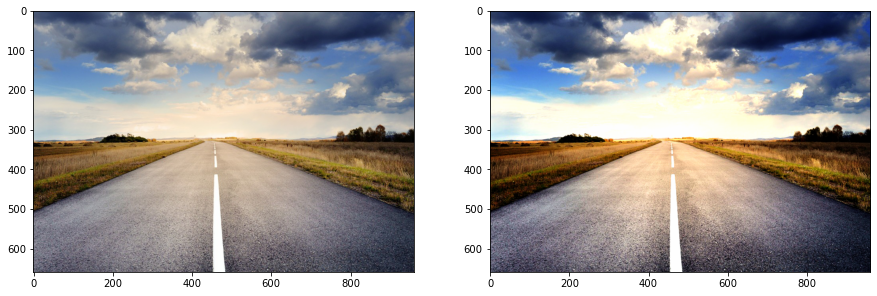

In [39]:
def lut_gamma(gamma):
    lut = np.power(np.arange(0,256),gamma) * np.power(255,1-gamma)
    return lut 
im2=lut_gamma(1.5)[im1]/256


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im2)

plt.show()

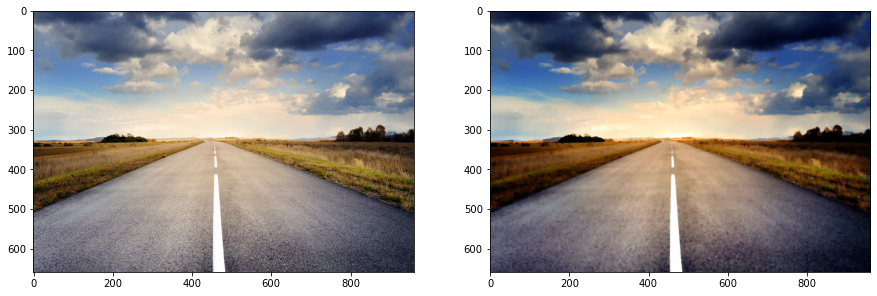

In [30]:
hsv = rgb2hsv(im2)

se = disk(2)
hsv[:,:,2] = opening(closing(hsv[:,:,2],se),se)
im3 = hsv2rgb(hsv)


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im3)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


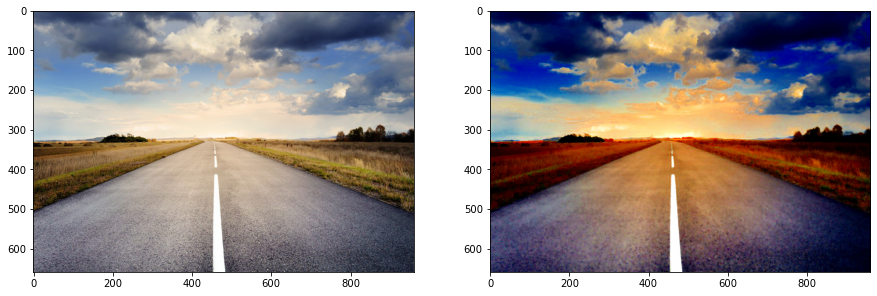

In [31]:
hsv = rgb2hsv(im3)

alpha=2
hsv[:,:,1] *=alpha 
im4 = hsv2rgb(hsv)
# print(hsv[:,:,1])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im4)

plt.show()

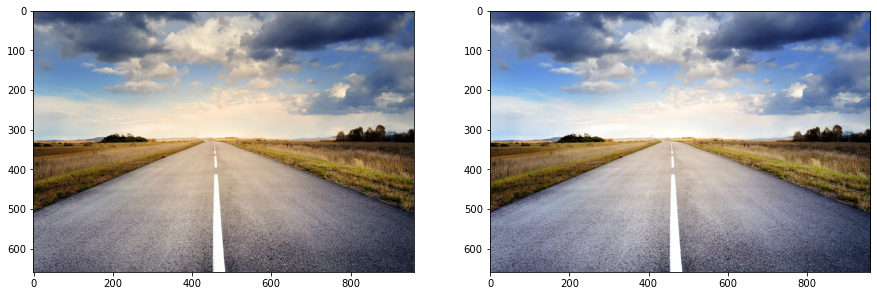

In [33]:
# 自动色阶亮度
def AutoBrightness(raw_img):
    rgb_min_output = 0
    rgb_max_output = 255
    channel_list = []

    # 计算各通道的直方图，确定输入的最大/小值
    channel_min_input = [np.min(raw_img[:,:,c]) for c in range(3)]
    channel_max_input = [np.max(raw_img[:,:,c]) for c in range(3)]   

    hist_list = []
    for i in range(3):
        hist_c, bin_edges = np.histogram(raw_img[:, :, i], bins=256, range=(0, 256), density=True)
        hist_list.append(hist_c)

    hist_array = np.array(hist_list)
    for c in range(3):
        sum = 0
        for index, element in enumerate(hist_array[c]):
            sum += element
            if sum > 0.99:
                channel_max_input[c] = index
                break

    # 计算各值的输出值
    for i in range(3):
        channel = [0] * (channel_max_input[i] + 1)        
        for x in range(channel_min_input[i], channel_max_input[i] + 1):
            output = rgb_min_output + \
                     (x - channel_min_input[i]) / \
                     (channel_max_input[i] - channel_min_input[i]) * \
                     (rgb_max_output - rgb_min_output) + 0.5
            channel[x] = output
        channel_list.append(channel)

    # 图像色阶调整
    dst = raw_img.copy()
    for w in range(raw_img.shape[0]):
        for h in range(raw_img.shape[1]):
            for c in range(3):
                try:
                    dst[w, h, c] = channel_list[c][raw_img[w, h, c]]
                except Exception as ex:
                    if raw_img[w, h, c] > channel_max_input[c]:
                        dst[w, h, c] = 255    
    return dst

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(AutoBrightness(im))
